In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
import matplotlib.colors as mcolors
from matplotlib import cm
from highlight_text import fig_text, ax_text
from matplotlib.patches import RegularPolygon

from mplsoccer import VerticalPitch

from PIL import Image
import urllib
import os

In [74]:
plt.style.use('../../assets/stylesheets/soc_base.mplstyle')
plt.rcParams['font.family'] = 'Nippo'

In [75]:
data = pd.read_csv('../../data/liga_mx.csv')

In [76]:
data = data[data['situation']!='Penalty'].reset_index(drop=True)

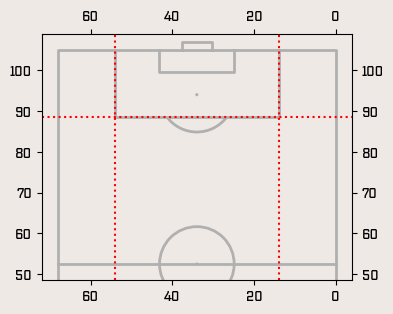

In [77]:
fig = plt.figure(figsize=(4,4), dpi=100)
ax = plt.subplot(111)
pitch = VerticalPitch(
    pitch_type='uefa',
    half=True,
    axis=True,
    label=True,
    tick=True,
    goal_type='box'
)
pitch.draw(ax = ax)

ax.plot([13.84,13.84],[ax.get_ylim()[0],ax.get_ylim()[1]],ls=':',color='red')
ax.plot([54.16,54.16],[ax.get_ylim()[0],ax.get_ylim()[1]],ls=':',color='red')

ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]],[88.5,88.5],ls=':',color='red')

In [78]:
def is_inside_box(x,y):
    if(x>=13.84)&(x<=54.16)&(y>=88.5):
        return True
    else:
        return False

In [79]:
data['is_in_box'] = [is_inside_box(x,y) for x,y in zip(data['y'],data['x'])]
data_groupped = data.groupby(['playerId','playerName','teamId','is_in_box'])['min'].count().reset_index()

In [80]:
data_groupped = data_groupped.pivot(columns='is_in_box',index=['playerId','playerName','teamId'],values='min').reset_index()
data_groupped.columns = ['playerId','playerName','teamId','False','True']
data_groupped.fillna(0,inplace=True)

In [81]:
data_groupped['total'] = data_groupped['False'] + data_groupped['True']
data_groupped['share'] = data_groupped['True']/data_groupped['total']


In [82]:
data_groupped = (
    data_groupped
    .sort_values(by='total', ascending=False)
    .head(12)
)

In [83]:
data = data[data['playerId'].isin(data_groupped['playerId'])].reset_index(drop=True)

In [84]:
colors = [
    '#d0d6d4',
    '#c5d0cd',
    '#bbcac7',
    '#b0c3c1',
    '#a6bdbb',
    '#9bb7b5',
    '#91b1af',
    '#86aaa8',
    '#7ca4a2',
    '#719e9c',
    '#679896',
    '#5c9190',
    '#528b8a',
    '#478583',
    '#3d7f7d',
    '#327877',
    '#287271',
]
soc_cm = mcolors.LinearSegmentedColormap.from_list('SOC', colors, N=50)
# cm.register_cmap(name='SOC', cmap=soc_cm)

In [85]:
import numpy as np
def semicircle(r,h,k):
    x0 = h-r
    x1 = h+r
    x = np.linspace(x0,x1,10000)
    y = k - np.sqrt(r**2-(x-h)**2)
    return x,y

In [90]:
def plot_hexbin_shot(ax, playerId):
    pitch = VerticalPitch(
        pitch_type='uefa',
        half=True,
        goal_type='box',
        linewidth=1.25,
        line_color='black',
        pad_bottom=-8,
        pad_top=10
    )
    pitch.draw(ax=ax)

    aux_data = data[data['playerId'] == playerId]
    bins = pitch.hexbin(x=aux_data['x'], y=aux_data['y'], ax=ax, cmap='SOC', gridsize=(
        14, 14), zorder=-1, edgecolors='#EFE9E6', alpha=.9, lw=.25)

    x_circle, y_circle = semicircle(104.8 - aux_data['x'].median(), 34, 104.8)
    ax.plot(x_circle, y_circle, ls='--', color='red', lw=.75)

    annot_x = [54-x*14 for x in range(0, 4)]
    annot_texts = ['goals', 'xG', 'shots', 'xG/shot']
    annot_stats = [aux_data[aux_data['eventType'] == 'Goal'].shape[0], aux_data['xG'].sum(
    ), aux_data.shape[0], aux_data['xG'].sum()/aux_data.shape[0]]

    for x, s, stat in zip(annot_x, annot_texts, annot_stats):
        hex_annotation = RegularPolygon(
            (x, 70), numVertices=6, radius=4.5, edgecolor='black', fc='None', hatch='.........', lw=1.25)
        ax.add_patch(hex_annotation)
        ax.annotate(
            xy=(x, 70),
            text=s,
            xytext=(0, -14),
            textcoords='offset points',
            size=5,
            ha='center',
            va='center'
        )
        if isinstance(stat, int):
            text_stat = f'{stat:.0f}'
        else:
            text_stat = f'{stat:.2f}'

        text_ = ax.annotate(
            xy=(x, 70),
            text=text_stat,
            xytext=(0, 0),
            textcoords='offset points',
            size=5,
            ha='center',
            va='center',
            weight='bold'
        )
        text_.set_path_effects([path_effects.Stroke(
            linewidth=1.5, foreground='#EFE9E6'), path_effects.Normal()])
    median_annotation = ax.annotate(
        xy=(34, 110),
        xytext=(x_circle[-1], 110),
        text=f"{((105 - aux_data['x'].median())):.1f} meters,",
        size=4,
        color='red',
        ha='right',
        va='center',
        arrowprops=dict(arrowstyle='<|-, head_width=.35, head_length=.65',
                        color='red', fc='#EFE9E6', lw=.75)
    )

    ax.annotate(
        xy=(34, 110),
        xytext=(4, 0),
        text=f"median distance",
        textcoords='offset points',
        size=4,
        color='red',
        ha='left',
        va='center',
        alpha=.5,
    )

    ax.annotate(
        xy=(34, 114),
        text=f"{aux_data['playerName'].iloc[0].upper()}",
        size=7.5,
        color='black',
        ha='center',
        va='center',
        weight='bold',
    )
    
    return ax


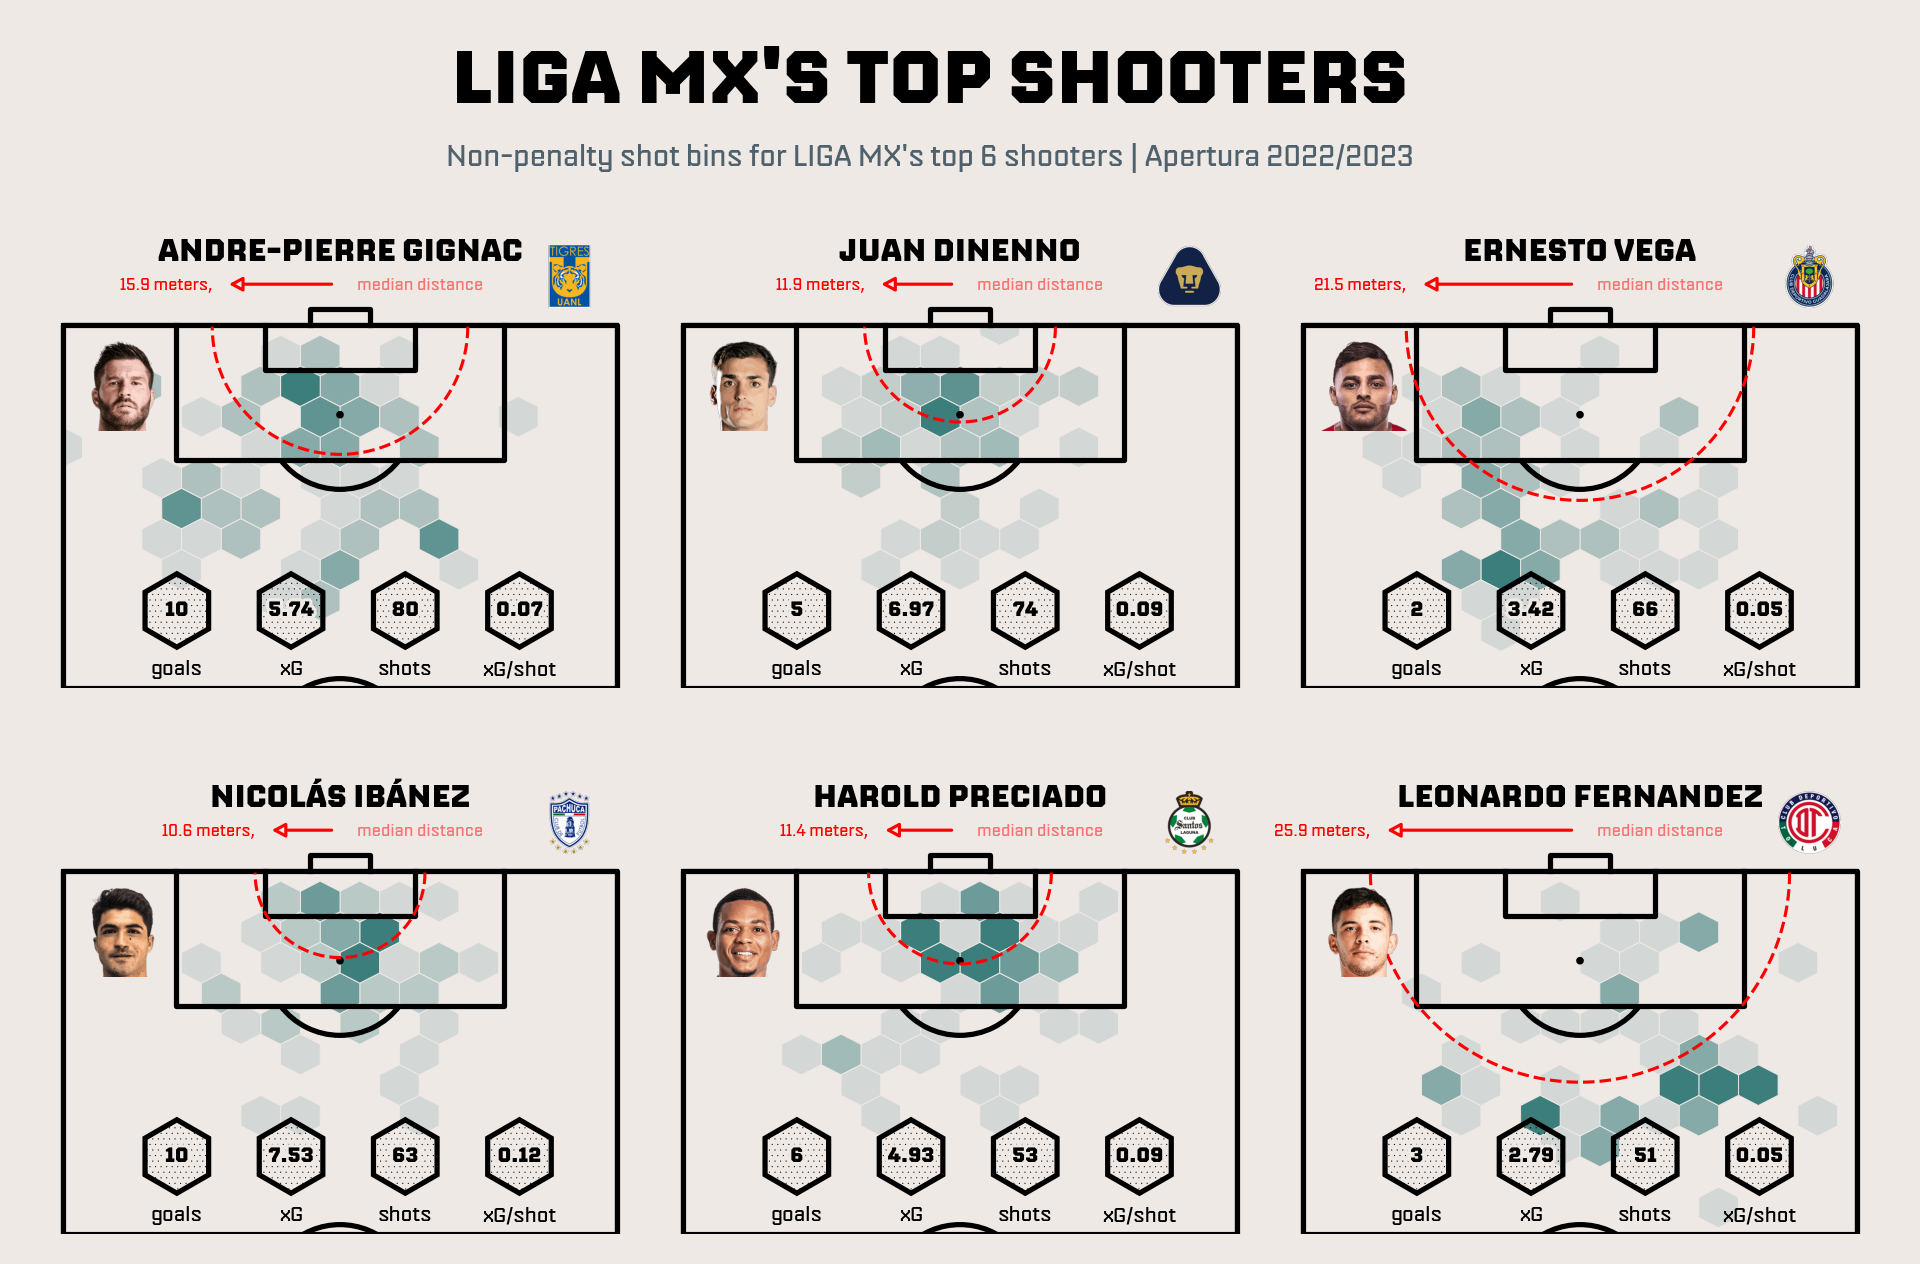

In [106]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(8, 6), dpi=300)
axs = np.array(axs)
plt.rcParams['hatch.linewidth'] = .02
for index, ax in enumerate(axs.reshape(-1)):
    plot_hexbin_shot(ax, data_groupped['playerId'].iloc[index])
plt.subplots_adjust(wspace=0, hspace=-.35)

for index, ax in enumerate(axs.reshape(-1)):
    DC_to_FC = ax.transData.transform
    FC_to_NFC = fig.transFigure.inverted().transform
    def DC_to_NFC(x): return FC_to_NFC(DC_to_FC(x))

    ax_coords = DC_to_NFC((11, 98))
    ax_size = .035
    image_ax = fig.add_axes(
        [ax_coords[0], ax_coords[1], ax_size, ax_size],
        fc='None'
    )
    fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'
    club_icon = Image.open(urllib.request.urlopen(
        f'{fotmob_url}{data_groupped["teamId"].iloc[index]:.0f}.png'))
    image_ax.imshow(club_icon)
    image_ax.axis('off')
    
    ax_coords2 = DC_to_NFC((68, 90))
    ax_size2 = .05
    image_ax2 = fig.add_axes(
        [ax_coords2[0], ax_coords2[1], ax_size2, ax_size2],
        fc='None'
    )
    player_img = 'https://images.fotmob.com/image_resources/playerimages/'
    club_icon2 = Image.open(urllib.request.urlopen(
        f'{player_img}{data_groupped["playerId"].iloc[index]:.0f}.png'))
    image_ax2.imshow(club_icon2)
    image_ax2.axis('off')

fig_text(
    x=.5, y=.84,
    s="LIGA MX'S TOP SHOOTERS",
    va="bottom", ha="center",
    fontsize=18, color="black", font="Nippo", weight="bold"
)

fig_text(
    x=.5, y=.81,
    s="Non-penalty shot bins for LIGA MX's top 6 shooters | Apertura 2022/2023",
    va="bottom", ha='center',
    fontsize=7, color="#4E616C", font="Nippo"
)

plt.savefig(
    "../../figures/soc/ligamx_shots.png",
    dpi=600,
    facecolor="#EFE9E6",
    bbox_inches="tight",
    edgecolor="none",
    transparent=False
)
